1. Read in all of the predicted (major topic) congress speech data (from multiple files. keep just party, cong_number, text, date, topic)
2. Keep only rows where party == democrat or republican 
3. Partition the data by major topic. 
4. Chunk into 2.5k character length rows
5. Tokenize:
	a. Remove Roberts Rules tokens
	b. Keep only tokens in the news data
	c. Only tokens that appear in 10 documents or more
6. Within each topic, predict party. Use Elastic Net. 
7. This will give you 21 models --- one for each topic
8. Output classification success of each.
9. Output top 20 Republican and Democrat words for each model.

### Update

1. May be the first thing to do with the news bigram/trigram data is to only keep bigrams/trigrams that appear in at least 100 articles.

### Update

When we are subetting the news data, we should limit bigrams that appear in 100 or more documents (for now) and trigrams that appear in 10 or more documents (for now). I think that is a good catch.



In [1]:
import pandas as pd
import numpy as np
import time

In [2]:
import nltk
from nltk import word_tokenize          
from nltk.stem.porter import PorterStemmer
import re
import string

stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

#def tokenize(text):
#    tokens = nltk.word_tokenize(text)
#    stems = stem_tokens(tokens, stemmer)
#    return stems

def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

%matplotlib inline
import matplotlib.pyplot as plt
from pandas_confusion import ConfusionMatrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cross_validation import train_test_split

with open('../roberts_rules/all_text.txt', 'rt') as f:
    text = f.read()
text = text.decode('ascii', 'ignore')
text = re.sub(r'\d+', '', text)

vect = CountVectorizer(tokenizer=tokenize, stop_words='english', ngram_range=(2, 3)) 
vect.fit([text])
roberts_rules = set(vect.get_feature_names())

def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    labelid = list(classifier.classes_).index(classlabel)
    feature_names = vectorizer.get_feature_names()
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print classlabel, feat, coef

def most_informative_feature_for_class_svm(vectorizer, classifier,  n=10):
    labelid = 3 # this is the coef we're interested in. 
    feature_names = vectorizer.get_feature_names()
    svm_coef = classifier.coef_.toarray() 
    topn = sorted(zip(svm_coef[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print feat, coef

def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (class_label,
              " | ".join(feature_names[j] for j in top10)))

def get_top_features(vectorizer, clf, class_labels, n=20):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    top_features = {}
    for i, class_label in enumerate(class_labels):
        topN = np.argsort(clf.coef_[i])[-n:]
        top_features[class_label] = [feature_names[j] for j in topN][::-1]
    return top_features

def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print "\t%.4f\t%-20s\t\t%.4f\t%-20s" % (coef_1, fn_1, coef_2, fn_2)

## Read Predicted Congress dataset

In [3]:
adf = None
for nth in range(107, 113):
    print nth
    df = pd.read_csv('../data/congress_%d_predict_major_label.csv' % nth) #, nrows=10)
    if adf is None:
        adf = df
    else:
        adf = pd.concat([adf, df])
adf

107
108
109
110
111
112


,date,text,party,topic,cong_number
0,2002-03-19,mr speaker yield minut gentleman virginia mr m...,100,20,107
1,2002-11-19,mr speaker would like submit appropri congress...,100,21,107
2,2002-06-06,mr speaker yesterday flight lo angel delay dep...,100,1,107
3,2002-03-06,mr speaker earlier today unabl cast vote two r...,100,3,107
4,2002-04-16,mr speaker thank gentleman yield time mr speak...,100,20,107
5,2002-10-01,mr speaker yield minut gentlewoman new york ms...,100,15,107
6,2001-10-16,mr speaker friday octob unavoid miss two roll ...,100,7,107
7,2002-05-09,mr chairman although disappoint rule bodi rise...,100,16,107
8,2002-10-01,mr speaker yield minut gentlewoman texa ms edd...,100,19,107
9,2002-10-01,mr speaker yield minut gentleman new jersey mr...,100,20,107


In [4]:
df = df[df.party.isin([100, 200])]

## Split long bill to smaller chunk (2500 chars)

In [5]:
import re
import textwrap

def insert_chars_split_marker(text, cc=2500):
    # FIXME: text still has number
    text = re.sub('\d+', '', text)
    out = '|'.join(textwrap.wrap(text, cc))
    return out

def insert_words_split_marker(text, wc=500):
    text = re.sub('\d+', '', text)
    words = text.split()
    out = ''
    for i, w in enumerate(words):
        if i != 0 and i % wc == 0:
            out += '|' + w
        else:
            out += ' ' + w
    return out

In [6]:
def remove_roberts_rules(all_vocab):
    vocab = []
    i = 0
    for a in all_vocab:
        if a not in roberts_rules:
            vocab.append(a)
        else:
            #print a
            i += 1
    print("Removed {0:d}".format(i))
    print("Total {0:d}".format(len(vocab)))
    return vocab


In [7]:
for t in df.topic.unique():
    if t != 1:
        continue
    sdf = df[df.topic == t]
    print t, len(sdf)
    
    if True:
        # split long text to multiple rows
        sdf.loc[:, 'text'] = sdf.text.astype(str).apply(lambda c: insert_chars_split_marker(c, 2500))
        s = sdf['text'].str.split('|', expand=True).stack()
        i = s.index.get_level_values(0)
        new_df = sdf.loc[i].copy()
        new_df['chunk'] = s.index.get_level_values(1)
        new_df['text'] = s.values
        sdf = new_df.reset_index(drop=True)
    
    print t, len(sdf)
    vect = CountVectorizer(ngram_range=(2, 3), min_df=10) 
    vect.fit(sdf.text)
    print len(vect.get_feature_names())
    
    vocab = remove_roberts_rules(vect.vocabulary_)
    print len(vocab)

    new_vocab = []
    ng = pd.read_csv('../data/major_%s_news_2gram_df100.csv' % t)
    for v in vocab:
        if v in ng.ngram.tolist():
            new_vocab.append(v)
    ng = pd.read_csv('../data/major_%s_news_3gram_df10.csv' % t)
    for v in vocab:
        if v in ng.ngram.tolist():
            new_vocab.append(v)
    break

1 3310


/opt/venv/local/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


1 4786
14160
Removed 399
Total 13761
13761


In [8]:
len(new_vocab)

11147

In [9]:
ng_df = pd.DataFrame(new_vocab)
ng_df.columns = ['ngram']
ng_df

,ngram
0,plan increas
1,second quarter
2,opportun someth
3,abl take
4,vote plan
5,yet still
6,face challeng
7,hope chang
8,close loophol
9,thank good


In [10]:
ng_df.to_csv('../data/major_%d_congress_23gram_new.csv' % t, index=False)

## Model (Party)

In [11]:
X = sdf.text
y = sdf.party

X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [12]:
#vect = CountVectorizer(ngram_range=(2, 3), min_df=20, vocabulary=vocab)
vect = CountVectorizer(ngram_range=(2, 3), min_df=10, vocabulary=new_vocab)

In [13]:
X_train = vect.transform(X_train)
transformer = TfidfTransformer()
X_train = transformer.fit_transform(X_train)

In [14]:
X_test = vect.transform(X_test)
transformer = TfidfTransformer()
X_test = transformer.fit_transform(X_test)

In [15]:
from sklearn.linear_model import SGDClassifier

elastic_clf = SGDClassifier(loss='log', alpha=.0001, n_iter=100, penalty="elasticnet")
t0 = time.time()
elastic_clf.fit(X_train, y_train)
t1 = time.time()
prediction_elastic = elastic_clf.predict(X_test)
t2 = time.time()
time_elastic_train = t1-t0
time_elastic_predict = t2-t1

print("Results for Elastic Net")
print("Training time: %fs; Prediction time: %fs" % (time_elastic_train, time_elastic_predict))
print(classification_report(y_test, prediction_elastic))

Results for Elastic Net
Training time: 0.427380s; Prediction time: 0.000604s
             precision    recall  f1-score   support

        100       0.88      0.75      0.81       410
        200       0.83      0.93      0.88       548

avg / total       0.85      0.85      0.85       958



In [16]:
most_informative_feature_for_class(vect, elastic_clf, 100)

100 higher tax 2.50222654018
100 incom tax 2.53162309427
100 tax hike 2.63614065439
100 feder govern 2.78479263838
100 debt crisi 2.82234224526
100 presid obama 2.9384152776
100 american peopl 3.09179785925
100 speaker ask unanim 3.17406129369
100 rais tax 4.08269686837
100 tax increas 4.15762645596


In [17]:
show_most_informative_features(vect, elastic_clf, 20)

	-6.2445	middl class         		4.1576	tax increas         
	-5.0183	deficit reduct      		4.0827	rais tax            
	-4.6257	tax cut             		3.1741	speaker ask unanim  
	-4.3905	tax break           		3.0918	american peopl      
	-3.7921	republican colleagu 		2.9384	presid obama        
	-3.4724	republican leader   		2.8223	debt crisi          
	-3.0003	reduc deficit       		2.7848	feder govern        
	-2.5673	presid move         		2.6361	tax hike            
	-2.3562	get done            		2.5316	incom tax           
	-2.3492	hous republican     		2.5022	higher tax          
	-2.3428	econom recoveri     		2.4928	white hous          
	-2.2970	republican budget   		2.4348	live within         
	-2.2505	georg bush          		2.4170	presid budget       
	-2.2497	work famili         		2.3181	may consid          
	-2.2180	presid ask unanim   		2.2423	death tax           
	-2.2020	laid upon tabl      		2.2293	spend reduct        
	-2.1915	make america        		2.1758	budget act        

In [18]:
def get_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top_a = coefs_with_fns[:n]
    top_b = coefs_with_fns[:-(n + 1):-1]
    return top_a, top_b

top_a, top_b = get_most_informative_features(vect, elastic_clf, 20)
top_a_df = pd.DataFrame(top_a)
top_a_df.columns = ['coef', 'term']
top_b_df = pd.DataFrame(top_b)
top_b_df.columns = ['coef', 'term']
top_a_df.to_csv('../data/major_%s_top20_rep_new.csv' % t, index=False)
top_b_df.to_csv('../data/major_%s_top20_dem_new.csv' % t, index=False)

In [19]:
from sklearn.externals import joblib

joblib.dump(vect, "../models/major_%s_vec_count_cong_23gram_new.joblib" % t)
joblib.dump(elastic_clf, "../models/major_%s_cong_clf_elastic_new.joblib" % t)

['../models/major_1_cong_clf_elastic_new.joblib',
 '../models/major_1_cong_clf_elastic_new.joblib_01.npy',
 '../models/major_1_cong_clf_elastic_new.joblib_02.npy',
 '../models/major_1_cong_clf_elastic_new.joblib_03.npy',
 '../models/major_1_cong_clf_elastic_new.joblib_04.npy']

In [20]:
y_test_df = pd.DataFrame(y_test).reset_index(drop=True)
y_test_df['predicted'] = prediction_elastic
y_test_df.to_csv('../data/major_%s_test_prediction_party_new.csv' % t, index=False)

In [21]:
y_true = y_test.reset_index(drop=True)
confusion_matrix = ConfusionMatrix(y_true, prediction_elastic)
print("Confusion matrix:\n%s" % confusion_matrix)

Confusion matrix:
Predicted  100  200  __all__
Actual                      
100        309  101      410
200         41  507      548
__all__    350  608      958


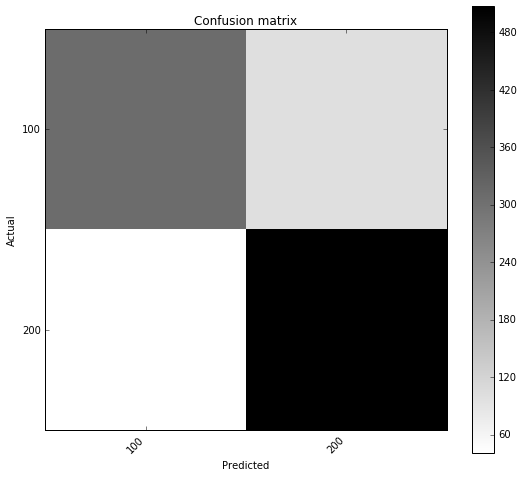

In [22]:
confusion_matrix.plot()

In [23]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_true, prediction_elastic)
conf_df = pd.DataFrame(conf)
conf_df.columns = elastic_clf.classes_
conf_df.index = elastic_clf.classes_
conf_df.to_csv('../data/major_%s_test_confusion_matrix_party_new.csv' % t, index_label="actual \ predicted")
conf_df

,100,200
100,309,101
200,41,507
